![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

# Destination Earth - OLCI Level 1B Reduced Resolution - Sentinel-3 - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[OLCI Level 1B Reduced Resolution - Sentinel-3](https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_1_ERR___NRT)

## Authenticate on DESP

In [2]:
import dedl_authentication as deauth

In [3]:
import requests
import json
import os
from getpass import getpass

In [4]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200


## Search data

Now, we search a product matching our filters.

For this example, we search data for the [OLCI Level 1B Reduced Resolution - Sentinel-3](https://hda.data.destination-earth.eu/ui/dataset/EO.EUM.DAT.SENTINEL-3.OL_1_ERR___) dataset. 

The corresponding collection ID in HDA for this dataset is: EO.EUM.DAT.SENTINEL-3.OL_1_ERR___.

In [5]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.EUM.DAT.SENTINEL-3.OL_1_ERR___"],
    "datetime": "2024-04-01T00:00:00Z/2024-04-19T00:00:00Z"
})


We can have a look at the metadata of the first products returned by the search.

In [6]:
from IPython.display import JSON

product = response.json()["features"][0]
JSON(product, expanded=True)

<IPython.core.display.JSON object>

### Download some assets of the product
To visualize a true color composition we will download the assets corresponding to the red, green and blue bands



In [7]:
from tqdm import tqdm
import time

# Define a list of numbers
assets = ["Oa08_radiance.nc", "Oa06_radiance.nc", "Oa02_radiance.nc"]
#assets = ["downloadLink"]

for asset in assets:
    download_url = product["assets"][asset]["href"]
    print(download_url)
    filename = asset
    print(filename)
    response = requests.get(download_url, headers=auth_headers)
    total_size = int(response.headers.get("content-length", 0))

    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)

https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.SENTINEL-3.OL_1_ERR___/items/S3B_OL_1_ERR____20240401T001732_20240401T010138_20240401T024232_2646_091_216______PS2_O_NR_003/download/Oa08_radiance.nc?provider=dedl
Oa08_radiance.nc
downloading Oa08_radiance.nc


28.1MB [00:00, 509MB/s]

https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.SENTINEL-3.OL_1_ERR___/items/S3B_OL_1_ERR____20240401T001732_20240401T010138_20240401T024232_2646_091_216______PS2_O_NR_003/download/Oa06_radiance.nc?provider=dedl
Oa06_radiance.nc


downloading Oa06_radiance.nc


27.7MB [00:00, 565MB/s]

https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.SENTINEL-3.OL_1_ERR___/items/S3B_OL_1_ERR____20240401T001732_20240401T010138_20240401T024232_2646_091_216______PS2_O_NR_003/download/Oa02_radiance.nc?provider=dedl
Oa02_radiance.nc


downloading Oa02_radiance.nc


26.4MB [00:00, 564MB/s]


### True Color visualization
True color composite uses visible light bands red, green  and blue, resulting in a natural colored result.

In [8]:
import rioxarray
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [9]:
#grid_reduce = 1
band_vars = xr.open_mfdataset("*.nc")
band_dict = {}

for band_var in band_vars:
    print(f"Reading:  {band_var}")
    #band_dict[band_var] = band_vars[band_var].data[::grid_reduce,::grid_reduce]
    band_dict[band_var] = band_vars[band_var].data[:]

band_vars.close()

Reading:  Oa02_radiance
Reading:  Oa06_radiance
Reading:  Oa08_radiance


In [10]:
# function from eumartool (https://anaconda.org/cmts/eumartools)
def normalise_image(grid_array, contrast=[1.0, 1.0, 1.0], unhitch=False):
    """Function to normalise an image using independant channels (unhitch=True)
        or combined channels (unhitch=False, default)

    Args:
        grid_array (numpy array): three-dimensional RGB array to be normalised
        contrast (list): non-linear (^2) channel scaling, e.g. [1.0 1.0 1.0]
        unhitch (bool): switch for independant or cross-channel normalisation

    Returns:
        if successful, the normalised array
        else returns an error
    """

    try:
        img_array = grid_array.copy()
        
        if unhitch:
            # normalise with separating channels
            for ii in range(np.shape(img_array)[-1]):
                minval = np.nanmin(img_array[:, :, ii])
                maxval = np.nanmax(img_array[:, :, ii])
                img_array[:, :, ii] = (img_array[:, :, ii] - minval) / (
                    maxval - minval
                )
                # apply contrast
                img_array[:, :, ii] = img_array[:, :, ii] ** contrast[ii]
        else:
            # normalise without separating channels
            minval = np.nanmin(img_array)
            maxval = np.nanmax(img_array)
            for ii in range(np.shape(img_array)[-1]):
                img_array[:, :, ii] = (img_array[:, :, ii] - minval) / (
                    maxval - minval
                )
                # apply contrast
                img_array[:, :, ii] = img_array[:, :, ii] ** contrast[ii]

            # non-linearity: contrast - note that the range is not between
            # 0 and 1, so need to renormalise afterwards
            minval = np.nanmin(img_array)
            maxval = np.nanmax(img_array)
            for ii in range(np.shape(img_array)[-1]):
                img_array[:, :, ii] = (img_array[:, :, ii] - minval) / (
                    maxval - minval
                )

        return img_array
    except Exception as error:
        msg = "Unsuccessful!", error, "occurred."
        print(msg)
        return msg

In [11]:
red_recipe = band_dict['Oa08_radiance']
green_recipe = band_dict['Oa06_radiance']
blue_recipe = band_dict['Oa02_radiance']

In [12]:
rgb_nat = np.dstack((red_recipe, green_recipe, blue_recipe))
rgb_nat_norm = normalise_image(rgb_nat)

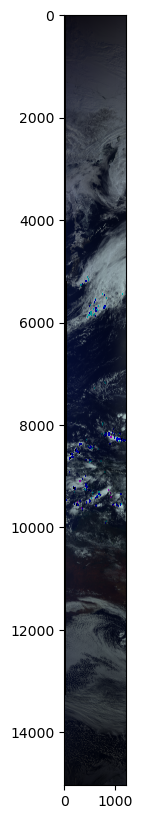

In [13]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(20, 10))
plt.imshow(rgb_nat_norm)